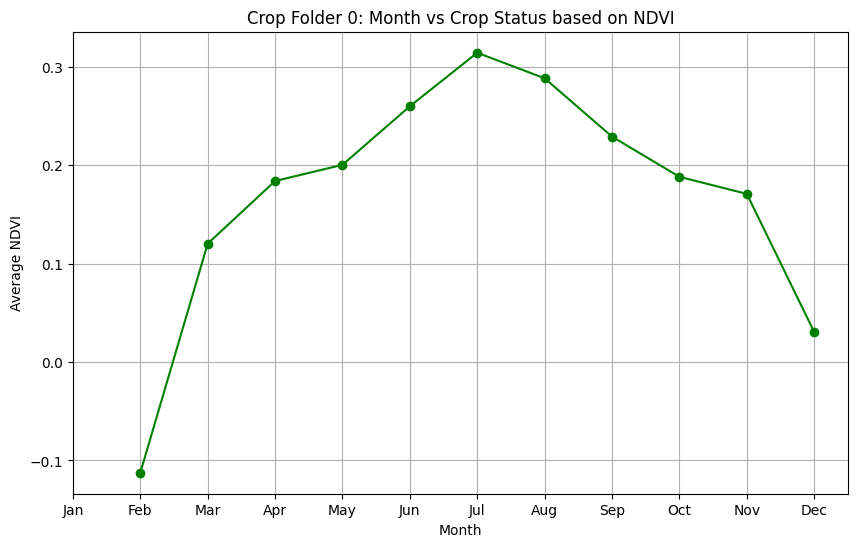

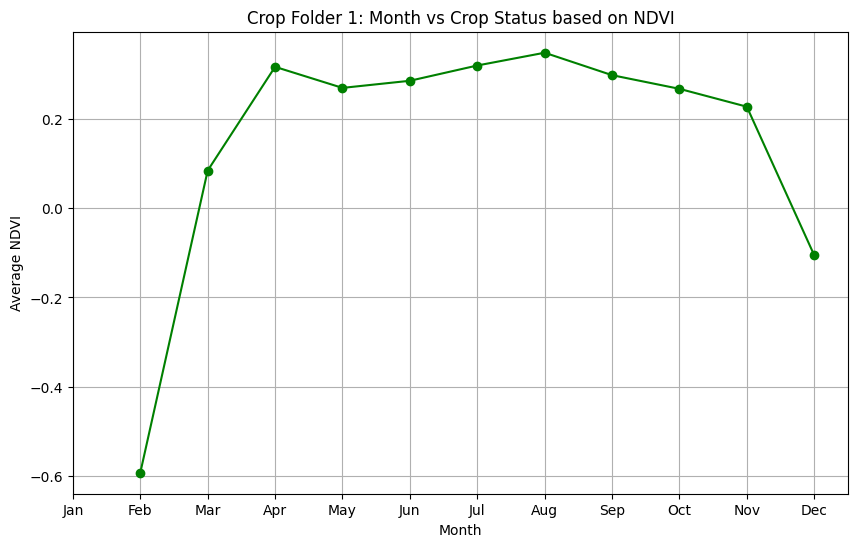

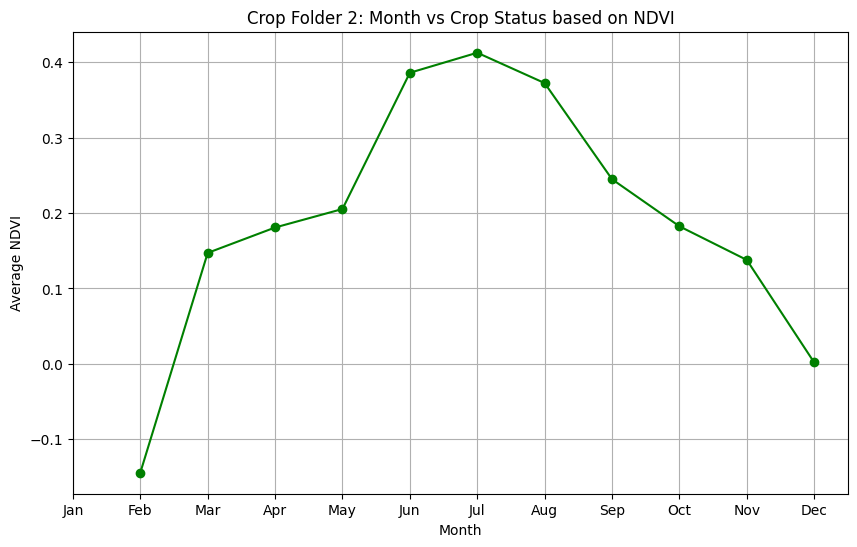

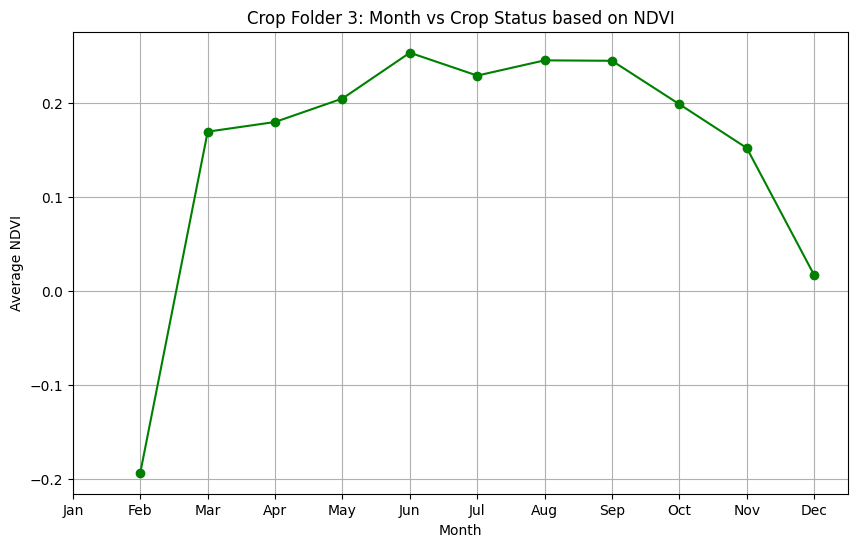

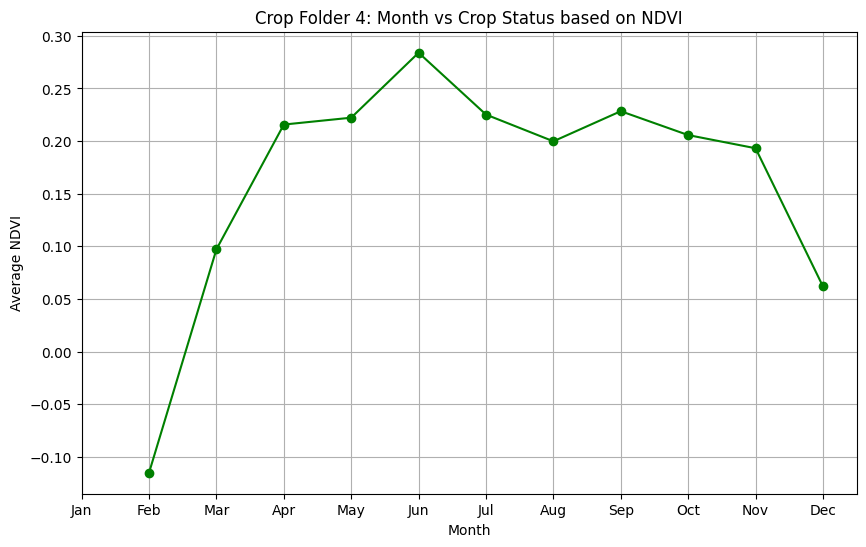

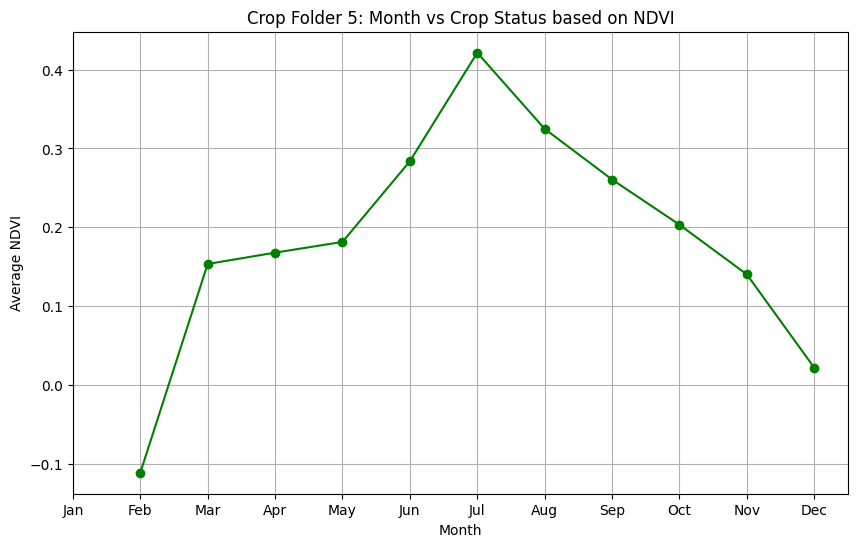

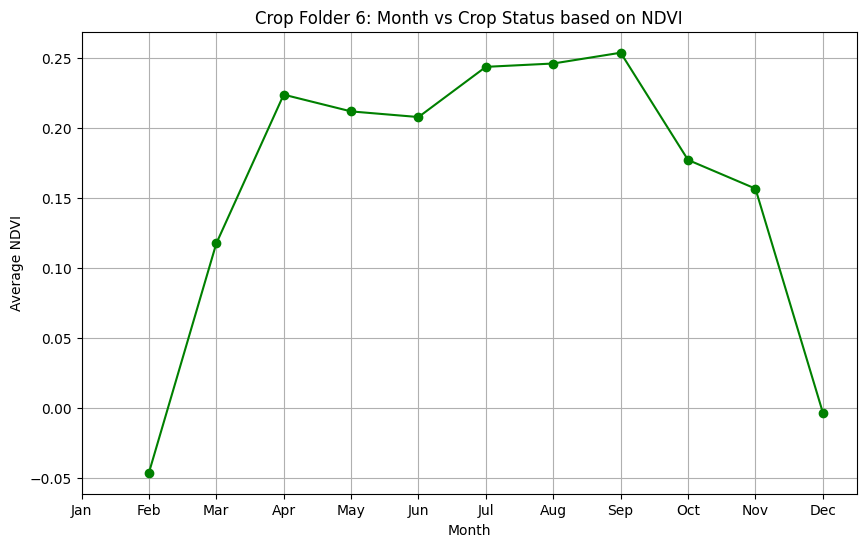

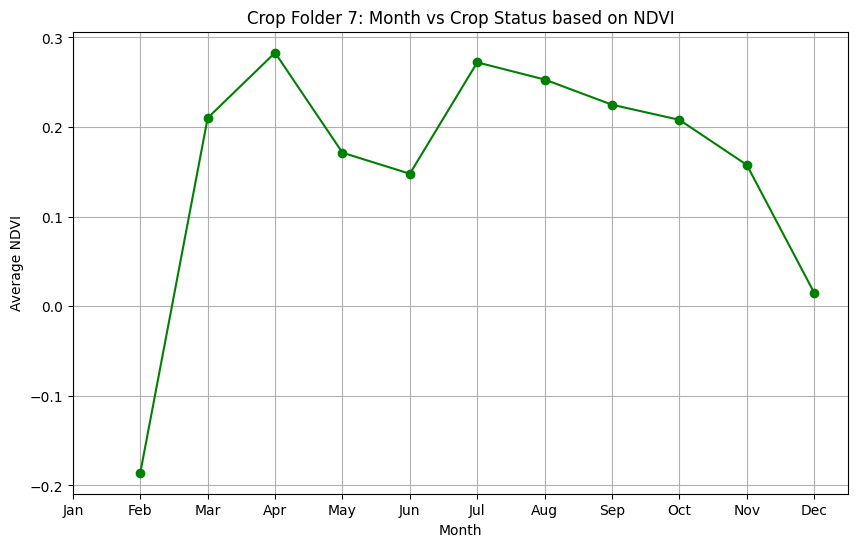

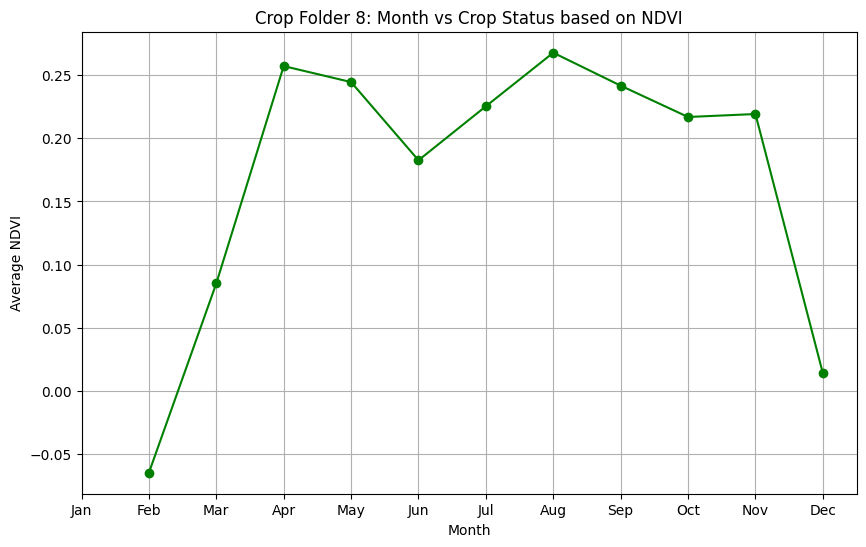

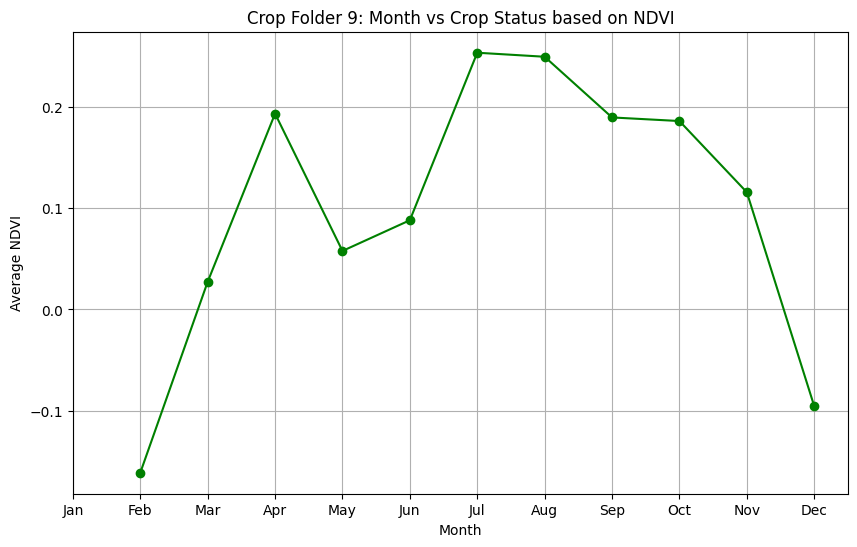

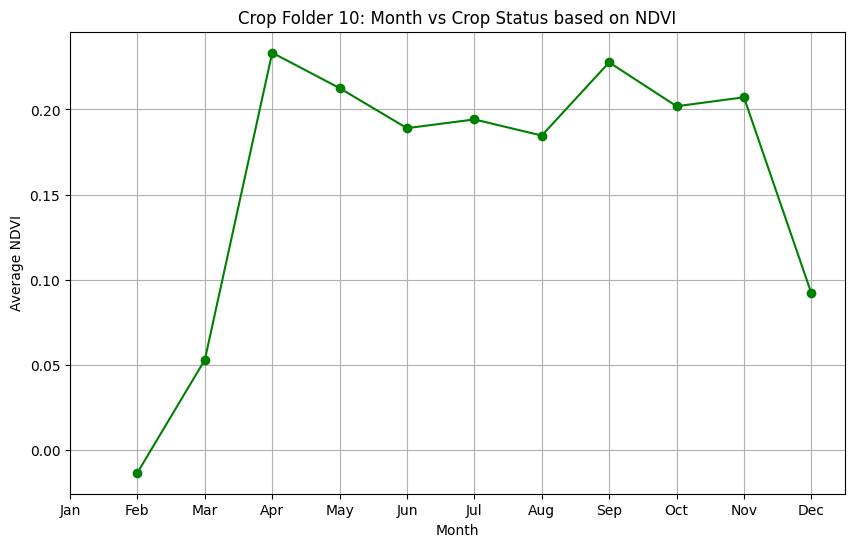

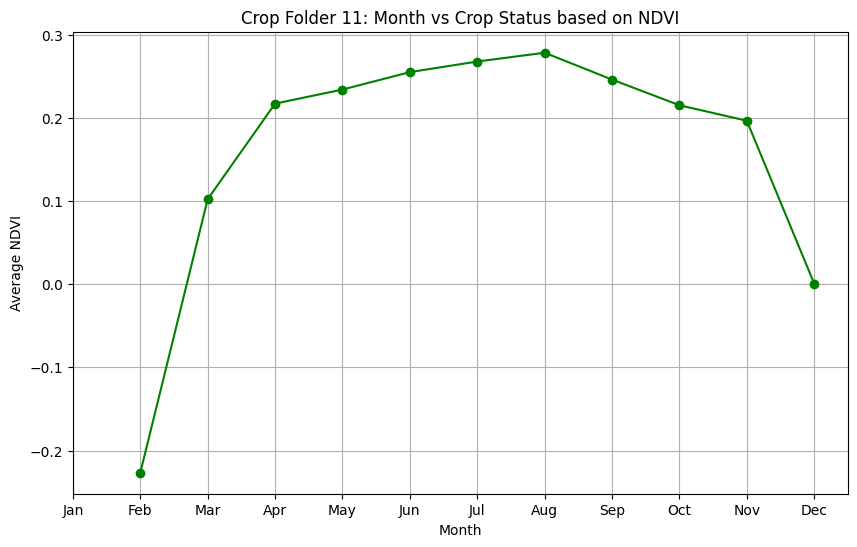

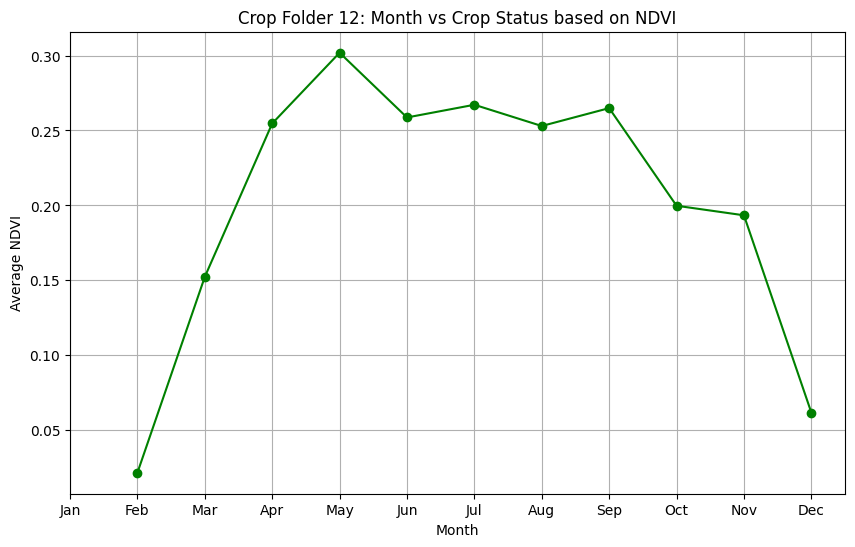

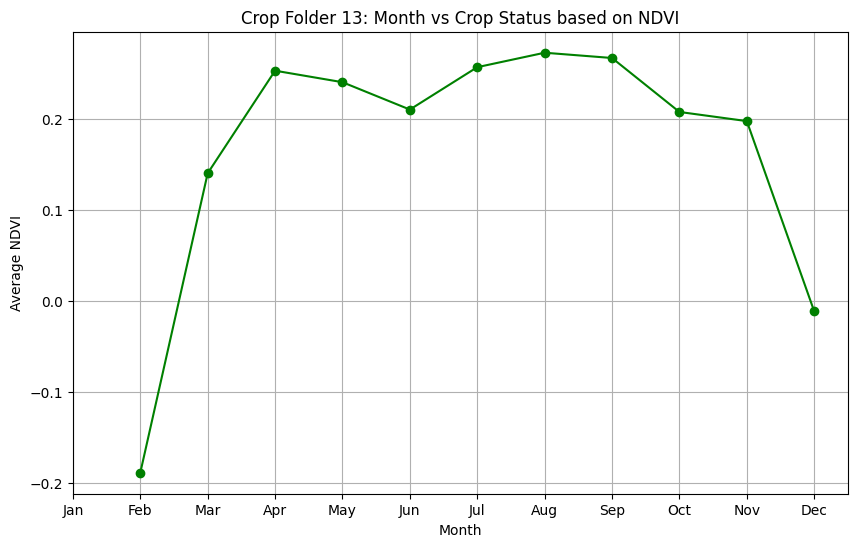

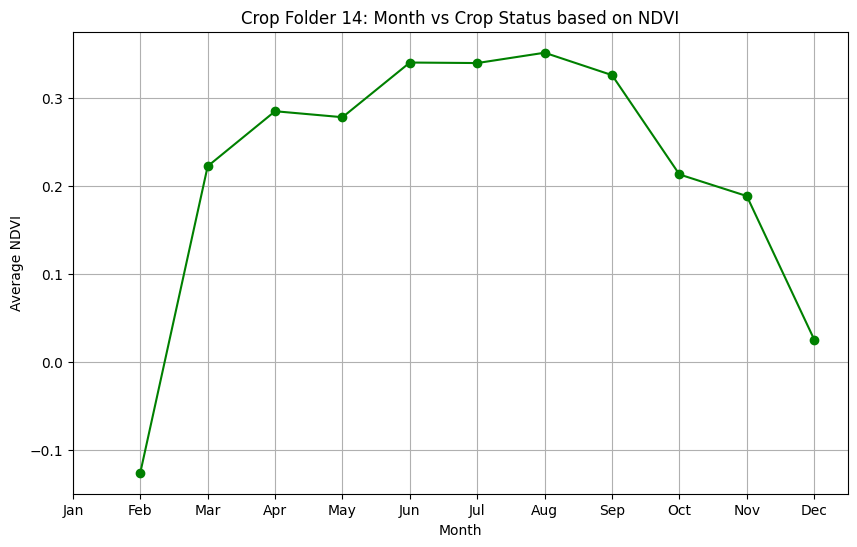

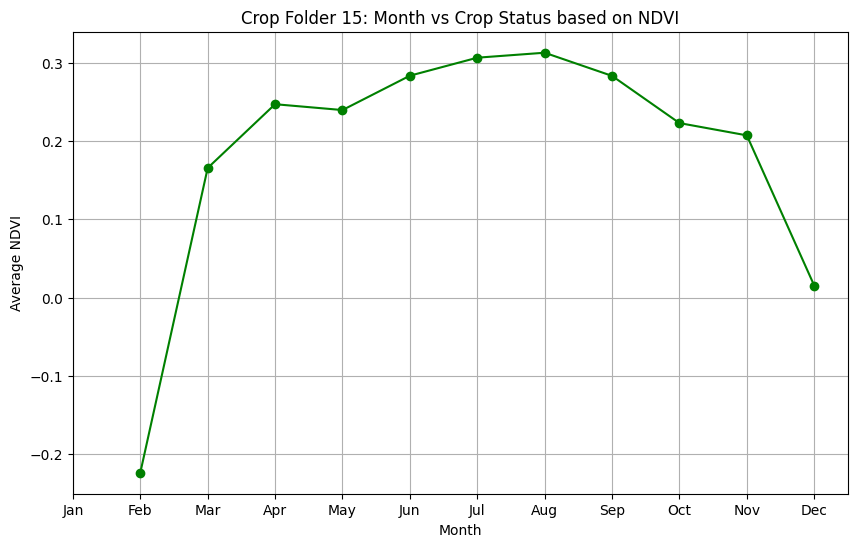


Dead crop Crops:
Crop Folder	Months
0		Feb
1		Feb, Dec
2		Feb
3		Feb
4		Feb
5		Feb
6		Feb, Dec
7		Feb
8		Feb
9		Feb, Dec
10		Feb
11		Feb
13		Feb, Dec
14		Feb
15		Feb

Unhealthy crop Crops:
Crop Folder	Months
0		Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
1		Mar, Apr, May, Jun, Jul, Sep, Oct, Nov
2		Mar, Apr, May, Sep, Oct, Nov, Dec
3		Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
4		Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
5		Mar, Apr, May, Jun, Aug, Sep, Oct, Nov, Dec
6		Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov
7		Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
8		Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
9		Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov
10		Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
11		Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
12		Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
13		Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov
14		Mar, Apr, May, Sep, Oct, Nov, Dec
15		Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec

Moderat

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import calendar

# Set the base path to the crop folders
base_path = "/workspace/awadh/nvidia/Vaibhav/Satellite_TSS2/TimeSen2Crop/validate/33TWN"

# Load dates data from dates.csv file
dates = pd.read_csv("/workspace/awadh/nvidia/Vaibhav/Satellite_TSS2/TimeSen2Crop/validate/33TWN/dates.csv")

# Function to determine crop status based on NDVI value
def get_crop_status(ndvi_value):
    if ndvi_value is None:
        return None
    elif ndvi_value < 0:
        return "Dead crop"
    elif 0 <= ndvi_value < 0.33:
        return "Unhealthy crop"
    elif 0.33 <= ndvi_value < 0.66:
        return "Moderately healthy crop"
    elif ndvi_value >= 0.66:
        return "Very healthy crop"

# Initialize dictionaries to store information about each crop status
crop_status_info = {status: {} for status in ["Dead crop", "Unhealthy crop", "Moderately healthy crop", "Very healthy crop"]}

# Loop through each crop folder (folders 0 to 15)
for crop_folder in range(16):
    # Set the path to the current crop folder
    crop_folder_path = os.path.join(base_path, str(crop_folder))

    # Get a list of all pixel csv files in the crop folder
    all_pixel_files = [file for file in os.listdir(crop_folder_path) if file.endswith(".csv")]

    # Check if there are any CSV files in the current crop folder
    if not all_pixel_files:
        print(f"Crop folder {crop_folder} does not contain any CSV files. No crops grow here.")
        continue

    # Initialize a dictionary to store NDVI values for each month for the current crop folder
    monthly_ndvi = {month: [] for month in range(1, 13)}

    # Loop through each pixel file in the current crop folder
    for pixel_file in all_pixel_files:
        # Load reflectance data from the pixel csv file
        data = pd.read_csv(os.path.join(crop_folder_path, pixel_file))

        # Append 'acquisition_date' column from dates.csv to data DataFrame
        data['acquisition_date'] = dates['acquisition_date']

        # Extract month from acquisition_date (5th and 6th digits)
        data['month'] = pd.to_datetime(data['acquisition_date'], format='%Y%m%d').dt.month

        # Filter rows with clear condition (Flag variable value 0) for each month
        for month in range(1, 13):
            clear_data_monthly = data.loc[(data['Flag'] == 0) & (data['month'] == month)].copy()
            if not clear_data_monthly.empty:
                clear_data_monthly['NDVI'] = (clear_data_monthly['B8'] - clear_data_monthly['B4']) / (clear_data_monthly['B8'] + clear_data_monthly['B4'])
                monthly_ndvi[month].extend(clear_data_monthly['NDVI'])

    # Calculate average NDVI values for each month
    average_ndvi_monthly = {month: sum(ndvi_values) / len(ndvi_values) if ndvi_values else None for month, ndvi_values in monthly_ndvi.items()}

    # Determine crop status for each month
    for month, ndvi_value in average_ndvi_monthly.items():
        status = get_crop_status(ndvi_value)
        if status:
            if crop_folder in crop_status_info[status]:
                crop_status_info[status][crop_folder].append(calendar.month_name[month][:3])  # Use only the first 3 letters of the month name
            else:
                crop_status_info[status][crop_folder] = [calendar.month_name[month][:3]]  # Use only the first 3 letters of the month name

    # Plot graph of month vs crop status
    plt.figure(figsize=(10, 6))
    plt.plot(average_ndvi_monthly.keys(), average_ndvi_monthly.values(), marker='o', linestyle='-', color='green')  # Change color to green
    plt.title(f'Crop Folder {crop_folder}: Month vs Crop Status based on NDVI')
    plt.xlabel('Month')
    plt.ylabel('Average NDVI')
    plt.xticks(range(1, 13), [calendar.month_name[i][:3] for i in range(1, 13)])  # Use only the first 3 letters of the month name
    plt.grid(True)
    plt.show()

# Display table of crops for each status
for status, crop_info in crop_status_info.items():
    print(f"\n{status.capitalize()} Crops:")
    print("Crop Folder\tMonths")
    for crop_folder, months in crop_info.items():
        print(f"{crop_folder}\t\t{', '.join(months)}")
